In [1]:
import requests
import zipfile
import tarfile
import os
import spacy
import numpy as np

from pathlib import Path
from tqdm import tqdm
from munch import Munch
from collections import Counter, OrderedDict

def download_file(url: str, path: Path):
    resp = requests.get(url, stream=True)

    content_disp = resp.headers['content-disposition']

    if content_disp:
        pattern = 'filename='
        index = content_disp.find(pattern)

        if index > -1:
            name = content_disp[index+len(pattern):]
        else:
            name = url.split('/')[-1]
    else:
        name = url.split('/')[-1]

    dest = path / name

    tqdm_args = {
        'desc': name,
        'total': int(resp.headers.get('content-length', 0)),
        'unit': 'iB',
        'unit_scale': True,
        'unit_divisor': 1024
    }

    with open(dest, 'wb') as file, tqdm(**tqdm_args) as bar:
        for data in resp.iter_content(chunk_size=1024):
            size = file.write(data)
            bar.update(size)

    return dest

def _parallel_dataset(path: Path, prefix: str='parallel'):
    url = 'https://codeload.github.com/prasastoadi/parallel-corpora-en-id/zip/refs/heads/master'
    dest = download_file(url, path)

    with zipfile.ZipFile(dest, 'r') as zf:
        for f in zf.namelist():
            if f.endswith('.tgz'):

                with zf.open(f, 'r') as fo, tarfile.open(fileobj=fo, mode='r') as tf:
                    for m in tf.getmembers():
                        if m.name.endswith('.en') or '-EN-' in m.name:
                            tf.extract(m, path=path / prefix /'en')
                        else:
                            tf.extract(m, path=path / prefix / 'id')

    dest.unlink()
    
def _bilingual_dataset(path: Path, prefix: str='bilingual'):
    url = 'https://github.com/desmond86/Indonesian-English-Bilingual-Corpus/archive/refs/heads/master.zip'
    dest = download_file(url, path)

    with zipfile.ZipFile(dest, 'r') as zf:
        for f in zf.namelist():
            en = f.endswith('.en')
            id = f.endswith('.id')

            if en or id:
                dest_path = path / prefix / ('en' if en else 'id')
                dest_path.mkdir(parents=True, exist_ok=True)

                with zf.open(f, 'r') as fo, open(dest_path / os.path.basename(f), 'wb') as t:
                    t.write(fo.read())

    dest.unlink()
    
def _talpco_dataset(path: Path, prefix: str='talpco'):
    url = 'https://github.com/matbahasa/TALPCo/archive/refs/heads/master.zip'
    dest = download_file(url, path)

    path_en = path / prefix / 'en'
    path_id = path / prefix / 'id'

    path_en.mkdir(parents=True, exist_ok=True)
    path_id.mkdir(exist_ok=True)

    file_to_path = [
        ('data_eng.txt', path_en),
        ('data_ind.txt', path_id)
    ]

    with zipfile.ZipFile(dest, 'r') as zf:
        for f in zf.namelist():
            for fn, p in file_to_path:
                if f.endswith(fn):
                    
                    with zf.open(f, 'r') as fo, open(p / fn, 'w') as t:
                        items = []
                        for line in fo.readlines():
                            split = line.decode('UTF-8').split('\t')
            
                            if len(split) > 1:
                                items.append(split[1].replace('\r', ''))
                        
                        t.writelines(items)
                        
    dest.unlink()
    
def download_all(path: str='raw_data'):
    path = Path(path)
    path.mkdir(exist_ok=True)
    
    print('Downloading data')

    # _parallel_dataset(path)
    _bilingual_dataset(path)
    # _talpco_dataset(path)

    print('Finished downloading')

download_all()

Indonesian-English-Bilingual-Corpus-master.zip: 3.00MiB [00:01, 1.85MiB/s]


Finished downloading


In [2]:
def build_dataset(path='data',
                    data_path='raw_data',
                    langs=['en', 'id'],
                    test_size=0.2,
                    random_state=42):
    path = Path(path)        
    data_path = Path(data_path)

    if not data_path.exists():
        raise RuntimeError('No data is found, please download dataset first')

    path.mkdir(exist_ok=True)

    data = dict()
    last_len = -1

    print('Building dataset')

    for lang in langs:
        sent = []
        
        for name in data_path.iterdir():
            for d in (name / lang).iterdir():
                if d.is_file():
                    with open(d, 'r', encoding='UTF-8') as file:
                        # All sentences are already separated by a newline
                        for line in file.readlines():
                            sent.append(line.lower())

        data[lang] = np.array(sent)

        if last_len == -1:
            last_len = len(sent)
        elif last_len != len(sent):
            raise RuntimeError('Data length of sentence mismatch ({} -> {} ({}))'.format(last_len, len(sent), lang))


    state = np.random.get_state()
    np.random.seed(random_state)

    msk = np.random.rand(last_len) > test_size
    np.random.set_state(state)
    
    for lang in langs:
        with open(path / (lang + '_train.txt'), 'w', encoding='UTF-8') as file:
            file.writelines(data[lang][msk])
            
        with open(path / (lang + '_test.txt'), 'w', encoding='UTF-8') as file:
            file.writelines(data[lang][~msk])

    print('Finished building dataset')

build_dataset(test_size=0.2)

Building dataset
Finished building dataset


In [3]:
import torch
import torch.nn as nn
import torch.functional as F
import math

from torch import Tensor

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout: float, max_length: int=5000):
        super(PositionalEncoding, self).__init__()

        pos = torch.arange(0, max_length).reshape(max_length, 1)
        den = torch.exp(-torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)

        pos_emb = torch.zeros((max_length, emb_size))
        pos_emb[:, 0::2] = torch.sin(pos * den)
        pos_emb[:, 1::2] = torch.cos(pos * den)
        pos_emb = pos_emb.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_emb', pos_emb)

    def forward(self, token_emb):
        return self.dropout(token_emb + self.pos_emb[:token_emb.size(0), :])

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size: int):
        super(TokenEmbedding, self).__init__()

        self.emb = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens):
        return self.emb(tokens.long()) * math.sqrt(self.emb_size)

class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                encoder_layers: int,
                decode_layers: int,
                emb_size: int,
                nhead: int,
                src_vocab_size: int,
                tgt_vocab_size: int,
                dim_feedforward: int,
                dropout: float):
                
        super(Seq2SeqTransformer, self).__init__()

        self.pos_encoding = PositionalEncoding(emb_size, dropout=dropout)

        self.src_token_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_token_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        
        self.transformer = nn.Transformer(d_model=emb_size,
                                          nhead=nhead,
                                          num_encoder_layers=encoder_layers,
                                          num_decoder_layers=decode_layers,
                                          dim_feedforward=dim_feedforward,
                                          dropout=dropout)

        self.generator = nn.Linear(emb_size, tgt_vocab_size)
    
    def forward(self,
                src: Tensor,
                tgt: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_pad_mask: Tensor,
                tgt_pad_mask: Tensor,
                mem_key_pad_mask: Tensor):

        src_emb = self.pos_encoding(self.src_token_emb(src))
        tgt_emb = self.pos_encoding(self.tgt_token_emb(tgt))

        out_seq = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                   src_pad_mask, tgt_pad_mask,
                                   mem_key_pad_mask)

        return self.generator(out_seq)
        
    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.pos_encoding(self.src_token_emb(src)), src_mask)
    
    def decode(self, tgt: Tensor, mem: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.pos_encoding(self.tgt_token_emb(tgt)), mem, tgt_mask)

In [4]:
def generate_square_subsequent_mask(size):
    mask = (torch.triu(torch.ones((size, size), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, -1e9).masked_fill(mask == 1, float(0.0))

    return mask

def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=device).type(torch.bool)

    src_pad_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_pad_mask = (tgt == PAD_IDX).transpose(0, 1)

    return src_mask, tgt_mask, src_pad_mask, tgt_pad_mask

def train_epoch(model, opt, loss_fn, train_loader):
    model.train()
    losses = 0.0

    for src, tgt in train_loader:
        src = src.to(device)
        tgt = tgt.to(device)

        tgt_input = tgt[:-1, :]
        src_mask, tgt_mask, src_pad_mask, tgt_pad_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask, src_pad_mask, tgt_pad_mask, src_pad_mask)

        opt.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        opt.step()
        losses += loss.item()

    return losses / len(train_loader)

def evaluate(model, loss_fn, val_loader):
    model.eval()
    losses = 0.0

    for src, tgt in val_loader:
        src = src.to(device)
        tgt = tgt.to(device)

        tgt_input = tgt[:-1, :]
        src_mask, tgt_mask, src_pad_mask, tgt_pad_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_pad_mask, tgt_pad_mask, src_pad_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(val_loader)

In [5]:
import string

UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
specials = ['<unk>', '<pad>', '<sos>', '<eos>']

def token_transform(tokenizer, sent):
    tokens = []
    for tok in tokenizer(sent):
        tok = str(tok)

        if any(c.isdigit() for c in tok):
            continue

        if all(c in string.punctuation for c in tok):
            continue

        tokens.append(tok)

    return tokens

def vocab_transform(vocab, sent_tok):
    return [SOS_IDX] + \
           [vocab[tok] if tok in vocab.keys() else UNK_IDX for tok in sent_tok] + \
           [EOS_IDX]

def load_dataset(path: str='data',
                 src_lang: str='en',
                 tgt_lang: str='id'):
    path = Path(path)

    if not path.exists():
        raise RuntimeError('No data is found, please download and/or build dataset first')

    data = dict()

    for lang in [src_lang, tgt_lang]:
        token_ids = dict()
        vocab = dict()

        try:
            tokenizer = spacy.load(lang)
        except:
            tokenizer = spacy.blank(lang)

        for type in ['train', 'test']:
            sentences = []

            with open(path / (lang + '_' + type + '.txt'), 'r', encoding='UTF-8') as file:
                for line in file.readlines():
                    sentences.append(line.lower().rstrip('\n'))

            sent_tokens = []

            for sent in tqdm(sentences, f'Tokenizing data ({lang}/{type})'):
                sent_tokens.append(token_transform(tokenizer, sent))

            if type == 'train':
                counter = Counter()
                for tokens in sent_tokens:
                    counter.update(tokens)

                for tok in specials:
                    del counter[tok]

                sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[0])
                sorted_by_freq_tuples.sort(key=lambda x: x[1], reverse=True)
                ordered_dict = OrderedDict(sorted_by_freq_tuples)

                for symbol in specials[::-1]:
                    ordered_dict.update({symbol: 1})
                    ordered_dict.move_to_end(symbol, last=False)

                vocab = dict(zip(ordered_dict, range(len(ordered_dict))))

            token_ids[type] = []
            for sent_tok in sent_tokens:
                token_ids[type].append(vocab_transform(vocab, sent_tok))

        data[lang] = Munch(vocab=vocab, data=token_ids, tokenizer=tokenizer)

    return data

dataset = load_dataset()

Tokenizing data (id/test): 100%|██████████| 8030/8030 [00:01<00:00, 7319.48it/s]


In [6]:
for lang in ['en', 'id']:
    with open(lang + '_vocab.txt', 'w', encoding='UTF-8') as f:
        f.writelines('\n'.join(dataset[lang].vocab.keys()))

In [7]:
from torch.utils import data
from torch.nn.utils.rnn import pad_sequence
from timeit import default_timer as timer

src_lang = 'en'
tgt_lang = 'id'

train_batch_size = 40
val_batch_size = 40

class SequenceDataset(data.Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

def get_pair_set(data, type):
    return [(x, y) for x, y in zip(data[src_lang].data[type], data[tgt_lang].data[type])]

def collate_fn(batch):
    src_batch, tgt_batch = [], []

    for src_sample, tgt_sample in batch:
        src_batch.append(torch.tensor(src_sample))
        tgt_batch.append(torch.tensor(tgt_sample))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    
    return src_batch, tgt_batch

train_loader = data.DataLoader(dataset=SequenceDataset(get_pair_set(dataset, 'train')),
                        batch_size=train_batch_size,
                        collate_fn=collate_fn)

val_loader = data.DataLoader(dataset=SequenceDataset(get_pair_set(dataset, 'test')),
                        batch_size=val_batch_size,
                        collate_fn=collate_fn)

src_vocab_size = len(dataset[src_lang].vocab)
tgt_vocab_size = len(dataset[tgt_lang].vocab)

print('src vocab size: {}, tgt vocab size: {}'.format(src_vocab_size, tgt_vocab_size))

src vocab size: 18727, tgt vocab size: 18586


In [8]:
torch.cuda.empty_cache()

model = Seq2SeqTransformer(3, 3, 256, 8,
                           src_vocab_size, tgt_vocab_size,
                           256, 0.1)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [9]:
epochs = 90
losses = []

history = {'loss': [], 'val_loss': [], 'time': []}

for epoch in range(1, epochs+1):
    start_time = timer()
    train_loss = train_epoch(model, optimizer, loss_fn, train_loader)

    end_time = timer()
    val_loss = evaluate(model, loss_fn, val_loader)

    epoch_time = end_time - start_time

    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['time'].append(epoch_time)

    print((f'Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, Epoch time = {epoch_time:.3f}s'))

Epoch: 1, Train loss: 7.326, Val loss: 7.071, Epoch time = 81.908s
Epoch: 2, Train loss: 6.650, Val loss: 6.819, Epoch time = 75.558s
Epoch: 3, Train loss: 6.292, Val loss: 6.580, Epoch time = 75.631s
Epoch: 4, Train loss: 5.973, Val loss: 6.263, Epoch time = 76.119s
Epoch: 5, Train loss: 5.682, Val loss: 6.005, Epoch time = 75.606s
Epoch: 6, Train loss: 5.409, Val loss: 5.747, Epoch time = 75.652s
Epoch: 7, Train loss: 5.157, Val loss: 5.491, Epoch time = 75.624s
Epoch: 8, Train loss: 4.923, Val loss: 5.282, Epoch time = 75.688s
Epoch: 9, Train loss: 4.712, Val loss: 5.101, Epoch time = 75.306s
Epoch: 10, Train loss: 4.517, Val loss: 4.936, Epoch time = 89.099s
Epoch: 11, Train loss: 4.338, Val loss: 4.788, Epoch time = 89.914s
Epoch: 12, Train loss: 4.167, Val loss: 4.671, Epoch time = 89.906s
Epoch: 13, Train loss: 4.013, Val loss: 4.555, Epoch time = 89.903s
Epoch: 14, Train loss: 3.868, Val loss: 4.466, Epoch time = 89.909s
Epoch: 15, Train loss: 3.733, Val loss: 4.390, Epoch time

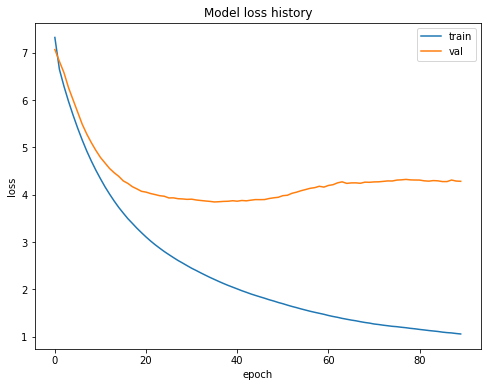

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

plt.title('Model loss history')
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [10]:
torch.save(model.state_dict(), 'model.pt')

In [9]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [10]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(device)
    src_mask = src_mask.to(device)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)

    for i in range(max_len-1):
        memory = memory.to(device)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0)).type(torch.bool)).to(device)

        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)

        prob = model.generator(out[:, -1])

        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        
        if next_word == EOS_IDX:
            break
    return ys

def translate(model: nn.Module, src_sentence: str):
    model.eval()

    src_sentence = src_sentence.lower()

    src = token_transform(dataset[src_lang].tokenizer, src_sentence)
    src = vocab_transform(dataset[src_lang].vocab, src)

    src = torch.tensor(src).view(-1, 1)

    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)

    tgt_tokens = greedy_decode(model, src, src_mask, max_len=num_tokens+5, start_symbol=SOS_IDX).flatten()

    tgt_tokens = [tok for tok in tgt_tokens.cpu().numpy() if tok not in (SOS_IDX, EOS_IDX)]

    return ' '.join([list(dataset[tgt_lang].vocab.keys())[tok] for tok in tgt_tokens])

In [36]:
texts = [
    'why are you so late',
    'what do you know',
    'it\'s a good day',
    'The decisive difference was revealed in the midst of the war',
    'everything written on them was unrepeatable since time immemorial and forever more',
]

for text in texts:
    print(f'input  (en): {text}')
    print(f'output (id): {translate(model, text)}')
    print()

input  (en): why are you so late
output (id): mengapa anda terlambat

input  (en): what do you know
output (id): apa yang anda ketahui

input  (en): it's a good day
output (id): hari ini sudah baik

input  (en): The decisive difference was revealed in the midst of the war
output (id): dalam estimasi selisih tersebut ditemukan pada pertengahan empat dari perang

input  (en): everything written on them was unrepeatable since time immemorial and forever more
output (id): segala sesuatu yang tertera sejak awal tahun tentang penyebab gagasan



In [11]:
texts = [
    'you\'re so smart',
    'you\'re pretty smart',
    'this is a beginning',
]

for text in texts:
    print(f'input  (en): {text}')
    print(f'output (id): {translate(model, text)}')
    print()

input  (en): you're so smart
output (id): anda terlalu pintar

input  (en): you're pretty smart
output (id): anda merasa cukup pintar

input  (en): this is a beginning
output (id): pada awal ini terdapat awal

